In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
import matplotlib.pyplot as plt

df = pd.read_csv('dataset.csv')

In [99]:
df = df.drop(columns=['Date'])
target = 'Revenue_(USD)'
X = df.drop(columns=[target])[740:]
y = df[target][740:]
display(X)

,Average_views_per_viewer,Unique_viewers,Click_rate_(%),Impressions,Comments,Shares,Dislikes,Likes,Average_viewed_(%),Videos_published,Views,Watch_hours,Average_view_sec,Subs_accumulated
740,1.6966,3342.0,5.45,80154.0,23.0,28.0,9.0,285.0,24.13,0.0,5670.0,281.0401,178.0,53213.0
741,1.7040,3703.0,5.40,89412.0,26.0,23.0,4.0,315.0,23.65,0.0,6310.0,310.0110,176.0,53387.0
742,1.7296,3565.0,5.69,82419.0,40.0,32.0,3.0,344.0,23.68,0.0,6166.0,305.4844,178.0,53582.0
743,1.6349,9602.0,6.96,162769.0,183.0,40.0,11.0,1602.0,30.79,1.0,15698.0,910.9613,208.0,53850.0
744,1.6092,9930.0,6.89,182250.0,78.0,55.0,13.0,997.0,28.86,0.0,15979.0,854.6027,192.0,54127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,2.2721,105872.0,4.04,4376635.0,546.0,399.0,195.0,10594.0,25.75,0.0,240554.0,19512.3516,292.0,565123.0
1128,1.8941,215712.0,5.83,4854638.0,2741.0,764.0,312.0,34422.0,30.35,4.0,408582.0,19855.7704,174.0,566855.0
1129,2.1319,305881.0,6.08,7768271.0,4741.0,1055.0,521.0,56677.0,47.81,0.0,652105.0,54463.2654,300.0,570139.0
1130,2.3468,152920.0,4.51,5788014.0,671.0,633.0,276.0,18458.0,41.24,0.0,358868.0,26757.4077,268.0,572582.0


# (a)

#### Hàm vòng lặp Huấn luyện mô hình K-NN và Đánh giá

In [100]:
def my_knn(X_data, y, datasets, splits, israndom):
    results = []
    # Vòng lặp qua các bộ dữ liệu (gốc và PCA)
    for data_name, X_data in datasets.items():

        # Vòng lặp qua các tỷ lệ chia
        for split_name, test_size in splits.items():

            # Chia dữ liệu train/test
            if israndom:
                X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=test_size, random_state=42)
            else:
                n_train = int((1 - test_size) * len(X_data))

                X_train = X_data[:n_train]
                y_train = y[:n_train]

                X_test = X_data[n_train:]
                y_test = y[n_train:]

            # Khởi tạo mô hình K-NN Regressor
            knn = KNeighborsRegressor()

            # Huấn luyện mô hình
            knn.fit(X_train, y_train)

            # Đánh giá mô hình tốt nhất trên tập train và test
            y_train_pred = knn.predict(X_train)
            y_test_pred = knn.predict(X_test)

            # Tính toán các chỉ số
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

            # Lưu kết quả
            results.append({
                "Loại dữ liệu": data_name,
                "Tỷ lệ (Train:Val)": split_name,
                "Train R2": train_r2,
                "Test R2": test_r2,
                "Train RMSE (USD)": train_rmse,
                "Test RMSE (USD)": test_rmse
            })

    return results

#### Hàm trực quan hóa kết quả đánh giá mô hình

In [101]:
def show_knn_results(results):
    # Chuyển sang DataFrame
    results_df = pd.DataFrame(results)

    # Làm tròn số
    results_df["Train R2"] = results_df["Train R2"].round(3)
    results_df["Test R2"] = results_df["Test R2"].round(3)
    results_df["Train RMSE (USD)"] = results_df["Train RMSE (USD)"].round(2)
    results_df["Test RMSE (USD)"] = results_df["Test RMSE (USD)"].round(2)

    print("\n📊 Kết quả tổng hợp KNN:")
    display(results_df.style.background_gradient(
        subset=["Train R2", "Test R2"], cmap="YlGn").background_gradient(
        subset=["Train RMSE (USD)", "Test RMSE (USD)"], cmap="YlOrRd_r"))

    # ---- BIỂU ĐỒ SO SÁNH ----
    plt.figure(figsize=(10, 6))

    for data_name in results_df["Loại dữ liệu"].unique():
        subset = results_df[results_df["Loại dữ liệu"] == data_name]

        # Đường Test R²
        plt.plot(
            subset["Tỷ lệ (Train:Val)"],
            subset["Test R2"],
            marker="o",
            label=f"{data_name} - Test R²",
            linestyle="-"
        )

        # Đường Train R²
        plt.plot(
            subset["Tỷ lệ (Train:Val)"],
            subset["Train R2"],
            marker="s",
            label=f"{data_name} - Train R²",
            linestyle="--"
        )

    plt.title("So sánh R² giữa các loại dữ liệu và tỷ lệ Train/Test")
    plt.xlabel("Tỷ lệ (Train:Val)")
    plt.ylabel("R²")
    plt.legend()
    plt.grid(True)
    plt.show()


### Chuẩn bị các bộ dữ liệu 1: Dữ liệu không biến đổi logarit

In [102]:
# a. Dữ liệu gốc (Đã chuẩn hóa)
# Chuẩn hóa là bắt buộc đối với K-NN và PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Số chiều dữ liệu gốc: {X_scaled.shape[1]}")

Số chiều dữ liệu gốc: 14


In [103]:
# b. Dữ liệu giảm chiều (PCA)
# Giữ lại 95% phương sai
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f"Số chiều sau khi giảm bằng PCA (giữ 95% phương sai): {X_pca.shape[1]}")

Số chiều sau khi giảm bằng PCA (giữ 95% phương sai): 6


#### Thiết lập Thử nghiệm với dữ liệu gốc

In [104]:
# Định nghĩa các bộ dữ liệu sẽ chạy
datasets = {
    "Dữ liệu gốc (Đã chuẩn hóa)": X_scaled,
    "Dữ liệu giảm chiều (PCA)": X_pca
}

# Định nghĩa các tỷ lệ chia
splits = {
    "4:1 (test=20%)": 0.2,
    "7:3 (test=30%)": 0.3,
    "6:4 (test=40%)": 0.4
}


#### Chạy mô hình và đánh giá với cách chia tập dữ liệu train-test ngẫu nhiên


📊 Kết quả tổng hợp KNN:


,Loại dữ liệu,Tỷ lệ (Train:Val),Train R2,Test R2,Train RMSE (USD),Test RMSE (USD)
0,Dữ liệu gốc (Đã chuẩn hóa),4:1 (test=20%),0.971000,0.967000,11.920000,9.270000
1,Dữ liệu gốc (Đã chuẩn hóa),7:3 (test=30%),0.971000,0.963000,12.440000,9.350000
2,Dữ liệu gốc (Đã chuẩn hóa),6:4 (test=40%),0.969000,0.958000,13.080000,11.140000
3,Dữ liệu giảm chiều (PCA),4:1 (test=20%),0.974000,0.959000,11.340000,10.270000
4,Dữ liệu giảm chiều (PCA),7:3 (test=30%),0.975000,0.959000,11.640000,9.910000
5,Dữ liệu giảm chiều (PCA),6:4 (test=40%),0.971000,0.954000,12.530000,11.570000


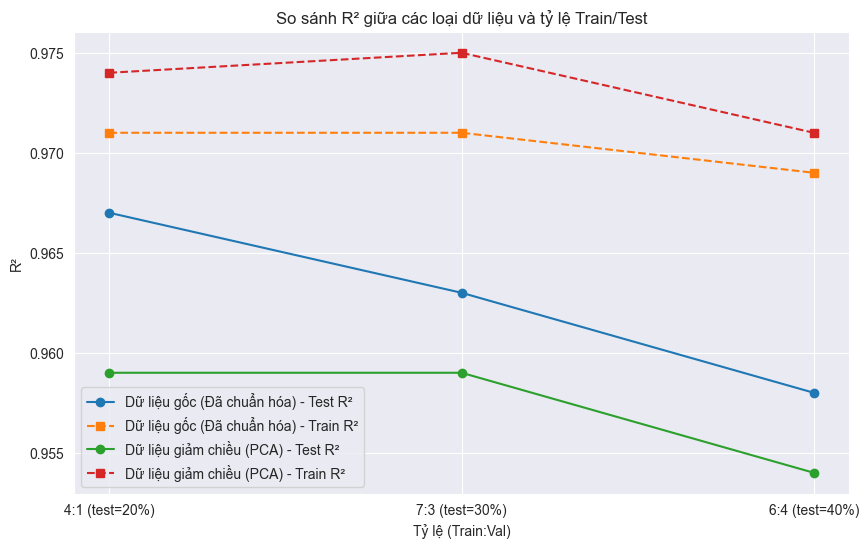

In [105]:
results = my_knn(X, y, datasets, splits, israndom = True)
show_knn_results(results)

#### Chạy mô hình và đánh giá với cách chia tập dữ liệu train-test tuần tự


📊 Kết quả tổng hợp KNN:


,Loại dữ liệu,Tỷ lệ (Train:Val),Train R2,Test R2,Train RMSE (USD),Test RMSE (USD)
0,Dữ liệu gốc (Đã chuẩn hóa),4:1 (test=20%),0.939000,0.397000,9.070000,58.680000
1,Dữ liệu gốc (Đã chuẩn hóa),7:3 (test=30%),0.951000,-0.202000,4.890000,79.740000
2,Dữ liệu gốc (Đã chuẩn hóa),6:4 (test=40%),0.905000,-0.692000,4.490000,93.890000
3,Dữ liệu giảm chiều (PCA),4:1 (test=20%),0.938000,0.384000,9.080000,59.290000
4,Dữ liệu giảm chiều (PCA),7:3 (test=30%),0.949000,-0.188000,4.980000,79.300000
5,Dữ liệu giảm chiều (PCA),6:4 (test=40%),0.903000,-0.687000,4.540000,93.750000


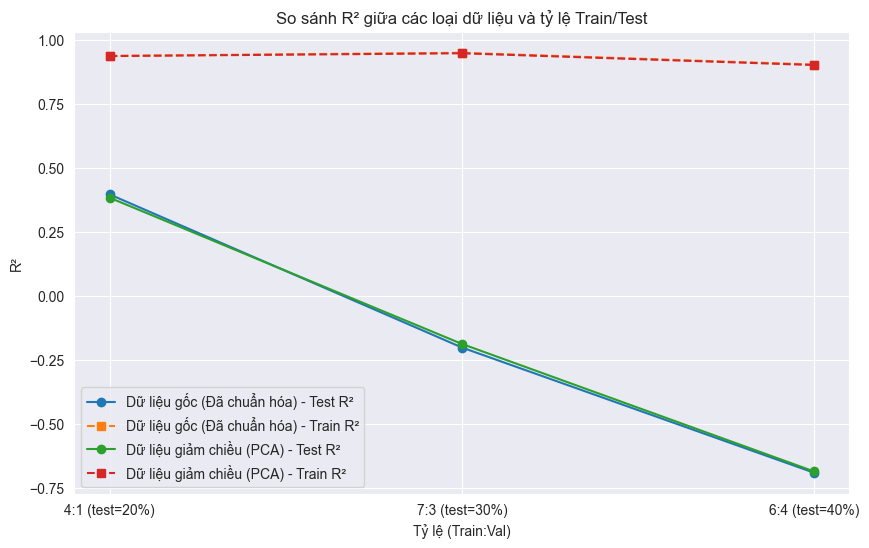

In [106]:
results = my_knn(X, y, datasets, splits, israndom = False)
show_knn_results(results)

### Chuẩn bị các bộ dữ liệu 2: Dữ liệu biến đổi logarit

In [107]:
X_log = np.log1p(X)
y_log = np.log1p(y)

# a. Dữ liệu biến đổi logarit (Đã chuẩn hóa)
# Chuẩn hóa là bắt buộc đối với K-NN và PCA
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)
print(f"Số chiều dữ liệu biến đổi logarit: {X_log_scaled.shape[1]}")

Số chiều dữ liệu biến đổi logarit: 14


In [108]:
# b. Dữ liệu giảm chiều (PCA)
# Giữ lại 95% phương sai
pca = PCA(n_components=0.95)
X_log_pca = pca.fit_transform(X_log_scaled)
print(f"Số chiều sau khi giảm bằng PCA (giữ 95% phương sai): {X_log_pca.shape[1]}")

Số chiều sau khi giảm bằng PCA (giữ 95% phương sai): 5


#### Thiết lập Thử nghiệm với dữ liệu logarit

In [109]:
# Định nghĩa các bộ dữ liệu sẽ chạy
datasets_log = {
    "Dữ liệu gốc (Đã chuẩn hóa)": X_log_scaled,
    "Dữ liệu giảm chiều (PCA)": X_log_pca
}

# Định nghĩa các tỷ lệ chia
splits_log = {
    "4:1 (test=20%)": 0.2,
    "7:3 (test=30%)": 0.3,
    "6:4 (test=40%)": 0.4
}


#### Chạy mô hình và đánh giá với cách chia tập dữ liệu train-test ngẫu nhiên


📊 Kết quả tổng hợp KNN:


,Loại dữ liệu,Tỷ lệ (Train:Val),Train R2,Test R2,Train RMSE (USD),Test RMSE (USD)
0,Dữ liệu gốc (Đã chuẩn hóa),4:1 (test=20%),0.985000,0.984000,0.160000,0.160000
1,Dữ liệu gốc (Đã chuẩn hóa),7:3 (test=30%),0.985000,0.981000,0.160000,0.170000
2,Dữ liệu gốc (Đã chuẩn hóa),6:4 (test=40%),0.986000,0.974000,0.160000,0.200000
3,Dữ liệu giảm chiều (PCA),4:1 (test=20%),0.984000,0.983000,0.170000,0.170000
4,Dữ liệu giảm chiều (PCA),7:3 (test=30%),0.985000,0.982000,0.160000,0.170000
5,Dữ liệu giảm chiều (PCA),6:4 (test=40%),0.987000,0.976000,0.150000,0.190000


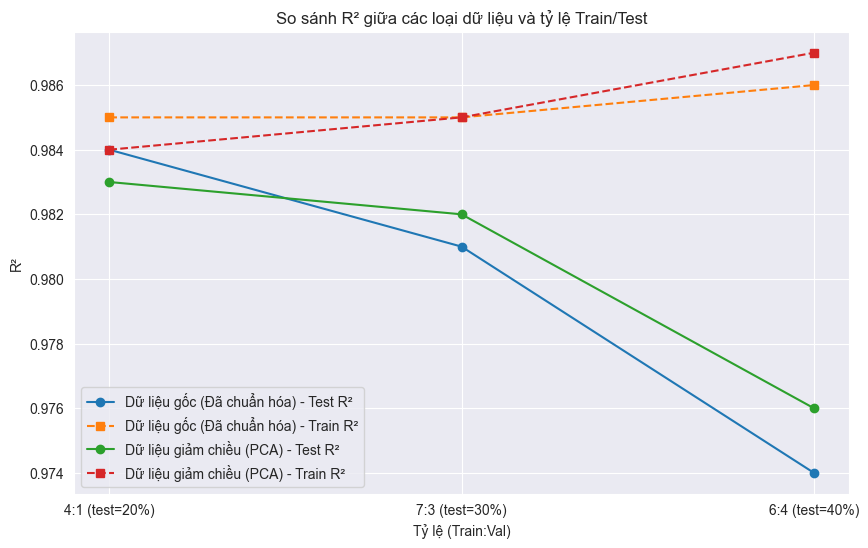

In [110]:
results_log = my_knn(X_log, y_log, datasets_log, splits_log, israndom = True)
show_knn_results(results_log)

#### Chạy mô hình và đánh giá với cách chia tập dữ liệu train-test tuần tự


📊 Kết quả tổng hợp KNN:


,Loại dữ liệu,Tỷ lệ (Train:Val),Train R2,Test R2,Train RMSE (USD),Test RMSE (USD)
0,Dữ liệu gốc (Đã chuẩn hóa),4:1 (test=20%),0.982000,-0.068000,0.150000,0.470000
1,Dữ liệu gốc (Đã chuẩn hóa),7:3 (test=30%),0.977000,-0.522000,0.140000,0.600000
2,Dữ liệu gốc (Đã chuẩn hóa),6:4 (test=40%),0.965000,-1.303000,0.150000,0.890000
3,Dữ liệu giảm chiều (PCA),4:1 (test=20%),0.981000,-0.073000,0.150000,0.470000
4,Dữ liệu giảm chiều (PCA),7:3 (test=30%),0.976000,-0.493000,0.150000,0.600000
5,Dữ liệu giảm chiều (PCA),6:4 (test=40%),0.963000,-1.295000,0.160000,0.890000


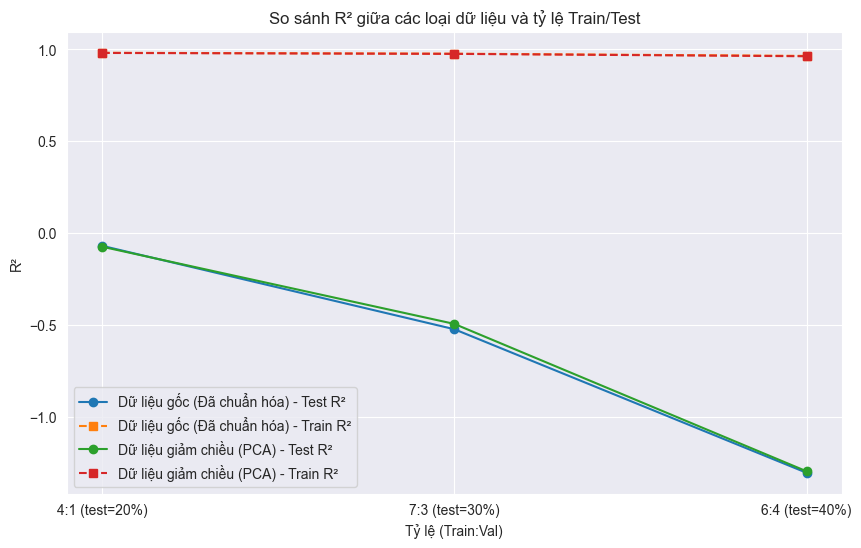

In [111]:
results_log = my_knn(X_log, y_log, datasets_log, splits_log, israndom = False)
show_knn_results(results_log)